# Download Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ismailnasri20/driver-drowsiness-dataset-ddd")

print("Path to dataset files:", path)

ModuleNotFoundError: No module named 'kagglehub'

# Split Data Into Train Validation Test Data Generators
80% Train
15% Validation
5% Test

In [2]:
! pip install split-folders
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = path + '/Driver Drowsiness Dataset (DDD)'
output_dir = '/content/'
splitfolders.ratio(data_dir, output=output_dir, seed=1337, ratio=(.8, 0.15, 0.05))

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

Copying files: 41793 files [00:22, 1888.65 files/s]


In [3]:
train_dir = "/content/train"
test_dir = "/content/test"
val_dir = "/content/val"

train_batches = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

test_batches = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary' ,
    shuffle=True
)

val_batches = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

Found 33434 images belonging to 2 classes.
Found 2091 images belonging to 2 classes.
Found 6268 images belonging to 2 classes.


# Visualize Dataset

classes are {'Drowsy': 0, 'Non Drowsy': 1}
The label is 1.0


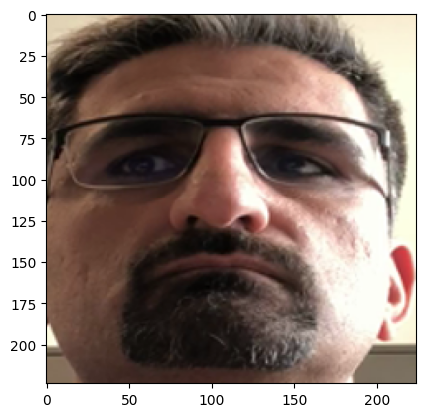

In [4]:
import matplotlib.pyplot as  plt

img, y = next(train_batches)
print(f'classes are {train_batches.class_indices}')
print(f'The label is {y[0]}')
plt.imshow(img[0])
plt.show()

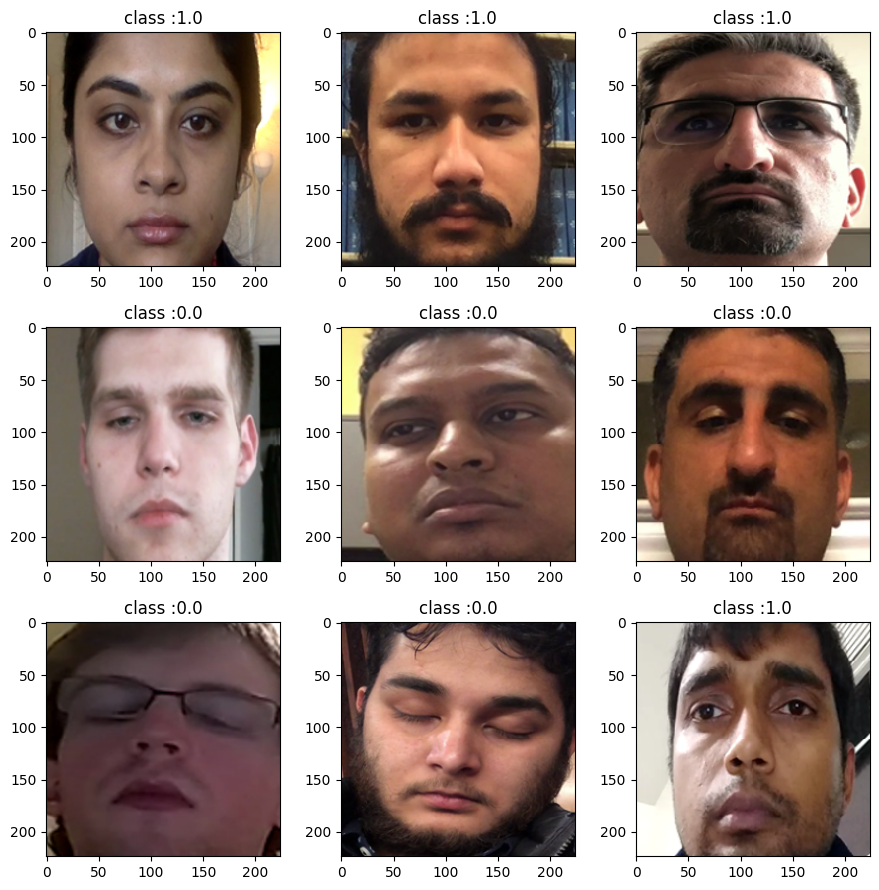

In [5]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    img, y = next(train_batches)
    for j in range(3):

        ax = axes[i, j]
        ax.imshow(img[j])
        label = int(y[j])
        ax.set_title(f'class :{y[j]}')

plt.tight_layout()
plt.show()


# CNN

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(256, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification: Drowsy vs Non Drowsy
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 128)       │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │       1,384,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,761,025 (6.72 MB)

 Trainable params: 1,761,025 (6.72 MB)

 Non-trainable params: 0 (0.00 B)

# Train Model

In [8]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(0.0001 ), loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
history = model.fit(
   train_batches,
    epochs=5,
    validation_data=val_batches,
    batch_size=32
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 279s 125ms/step - accuracy: 0.8823 - loss: 0.2329 - val_accuracy: 0.9986 - val_loss: 0.0062
Epoch 2/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 249s 119ms/step - accuracy: 0.9990 - loss: 0.0058 - val_accuracy: 0.9992 - val_loss: 0.0021
Epoch 3/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 248s 119ms/step - accuracy: 0.9991 - loss: 0.0037 - val_accuracy: 0.9997 - val_loss: 0.0016
Epoch 4/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 247s 118ms/step - accuracy: 0.9997 - loss: 8.9749e-04 - val_accuracy: 0.9992 - val_loss: 0.0018
Epoch 5/5
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 265s 127ms/step - accuracy: 0.9995 - loss: 0.0014 - val_accuracy: 0.9990 - val_loss: 0.0063


In [10]:
loss, accuracy = model.evaluate(train_batches)

print(f"Training Loss: {loss:.4f}")
print(f"Training Accuracy: {accuracy*100:.2f}%")

2090/2090 ━━━━━━━━━━━━━━━━━━━━ 133s 64ms/step - accuracy: 0.9988 - loss: 0.0036
Training Loss: 0.0037
Training Accuracy: 99.87%


# Test Model

In [11]:
loss, accuracy = model.evaluate(test_batches)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - accuracy: 0.9988 - loss: 0.0093
Test Loss: 0.0073
Test Accuracy: 99.90%


In [12]:
from tensorflow.io import read_file
from tensorflow.image import decode_jpeg, resize
import tensorflow
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    # Read the image file
    image = tensorflow.io.read_file(image_path)
    # Decode the JPG image
    image = tensorflow.image.decode_jpeg(image, channels=3)
    # Resize the image
    image = tensorflow.image.resize(image, target_size)
    # Normalize the image to [0, 1] range
    image = image / 255.0
    return image


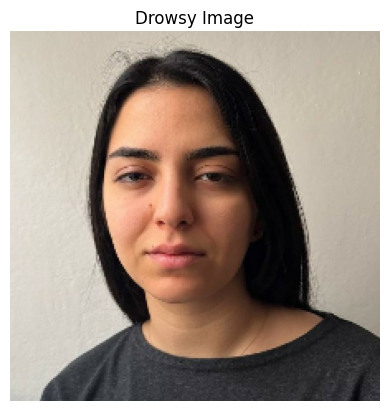

In [14]:
image_path = '/content/photo_2025-01-18_13-03-05.jpg'

# Preprocess the image
input_image = load_and_preprocess_image(image_path)

# Add batch dimension
input_image = tensorflow.expand_dims(input_image, axis=0)

plt.imshow(input_image.numpy()[0])
plt.title("Drowsy Image")
plt.axis("off")
plt.show()


In [15]:
# Run the image through the model
predictions = model(input_image)

# Display predictions
print(predictions)

tf.Tensor([[0.0001762]], shape=(1, 1), dtype=float32)


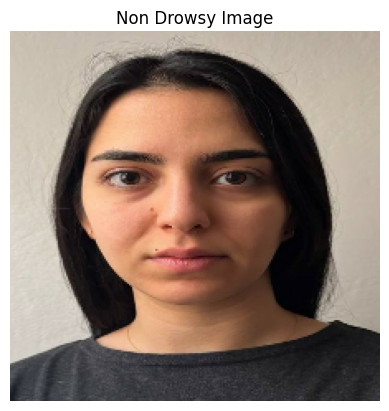

In [18]:
image_path = '/content/photo_2025-01-18_13-03-07.jpg'

# Preprocess the image
input_image = load_and_preprocess_image(image_path)

# Add batch dimension
input_image = tensorflow.expand_dims(input_image, axis=0)

plt.imshow(input_image.numpy()[0])
plt.title("Non Drowsy Image")
plt.axis("off")
plt.show()


In [17]:
# Run the image through the model
predictions = model(input_image)

# Display predictions
print(predictions)

tf.Tensor([[0.8611456]], shape=(1, 1), dtype=float32)


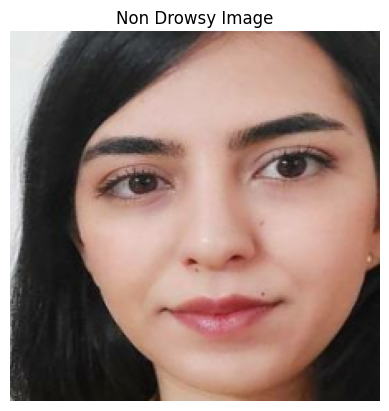

In [20]:
image_path = '/content/photo_2025-01-18_13-20-21.jpg'

# Preprocess the image
input_image = load_and_preprocess_image(image_path)

# Add batch dimension
input_image = tensorflow.expand_dims(input_image, axis=0)

plt.imshow(input_image.numpy()[0])
plt.title("Non Drowsy Image")
plt.axis("off")
plt.show()


In [21]:
# Run the image through the model
predictions = model(input_image)

# Display predictions
print(predictions)

tf.Tensor([[0.9997725]], shape=(1, 1), dtype=float32)


# Analytics

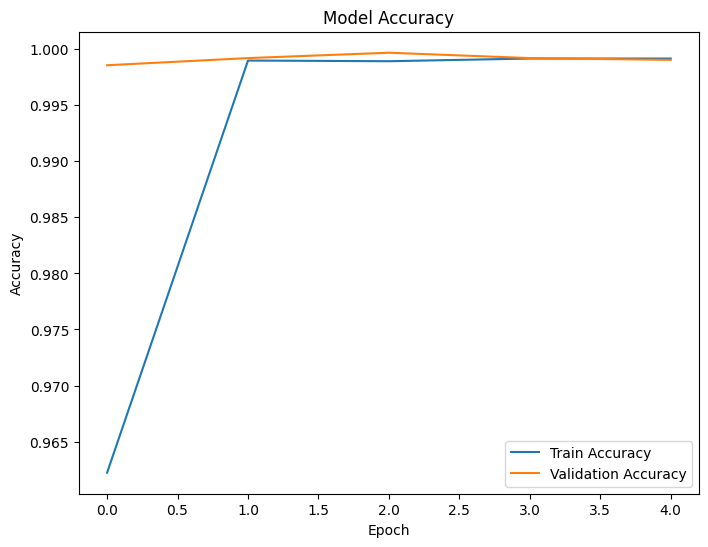

In [22]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


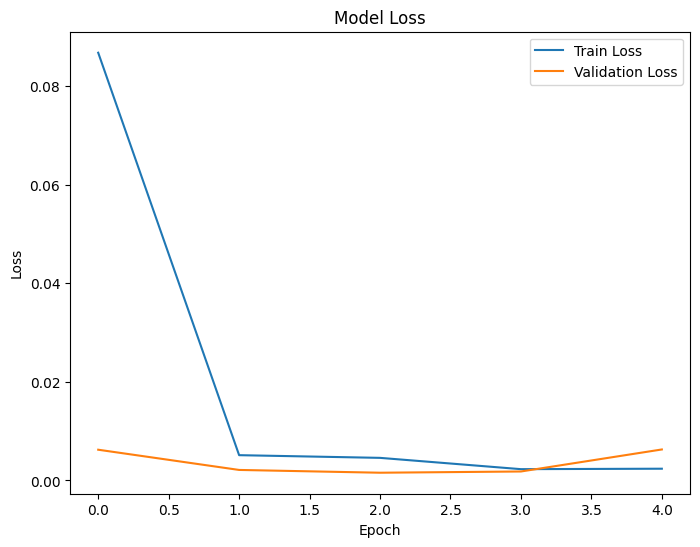

In [23]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


Found 2091 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step


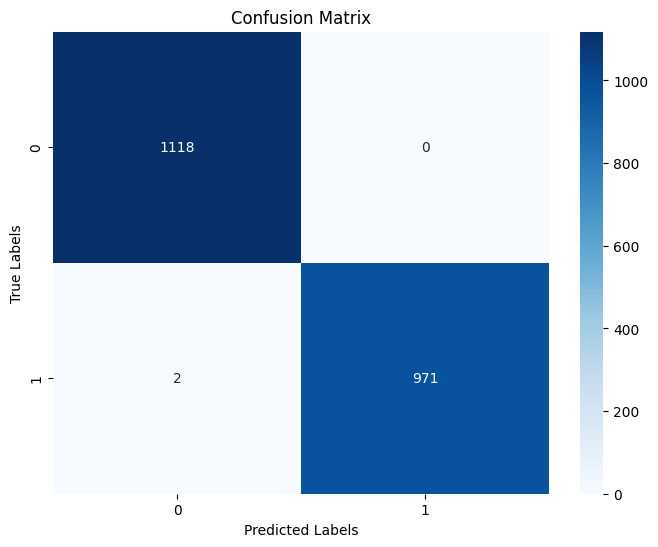

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_batches = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary' ,
    shuffle=False
)

test_batches.reset()  # Ensure the generator is at the start
predictions = model.predict(test_batches)
# Convert predictions to binary classes using a threshold of 0.5
predicted_classes = (predictions > 0.5).astype("int32").flatten()

# True labels from the test generator
true_classes = test_batches.classes
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()
